In [9]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

### Segundo Dataset

In [ ]:
!pip install ucimlrepo
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, accuracy_score

In [11]:
# fetch dataset 
contraceptive_method_choice = fetch_ucirepo(id=30) 
  
# data (as pandas dataframes) 
X = contraceptive_method_choice.data.features 
y = contraceptive_method_choice.data.targets 
  
# metadata 
print(contraceptive_method_choice.metadata) 
  
# variable information 
print(contraceptive_method_choice.variables) 

print ("Targets:")
print(y)

{'uci_id': 30, 'name': 'Contraceptive Method Choice', 'repository_url': 'https://archive.ics.uci.edu/dataset/30/contraceptive+method+choice', 'data_url': 'https://archive.ics.uci.edu/static/public/30/data.csv', 'abstract': 'Dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1473, 'num_features': 9, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Education Level', 'Other', 'Occupation'], 'target_col': ['contraceptive_method'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C59W2D', 'creators': ['Tjen-Sien Lim'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either

## Tratamento dos datasets

### Visualização de datasets

In [12]:
print("Features:")
print(X.head())
print("\nTargets:")
print(y)
    
# Obter os metadados corretamente
variables = contraceptive_method_choice.variables

# Identificar colunas categóricas automaticamente (tipo = 'Categorical' ou 'Binary', role = 'Feature')
categorical_types = ['Categorical', 'Binary']
categorical_cols = variables[
    (variables['type'].isin(categorical_types)) &
    (variables['role'] == 'Feature')
]['name'].tolist()

# Converter essas colunas para 'category'
X[categorical_cols] = X[categorical_cols].astype('category')

# Verificar categorias e numéricos
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("Colunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)



Features:
   wife_age  wife_edu  husband_edu  num_children  wife_religion  wife_working  \
0        24         2            3             3              1             1   
1        45         1            3            10              1             1   
2        43         2            3             7              1             1   
3        42         3            2             9              1             1   
4        36         3            3             8              1             1   

   husband_occupation  standard_of_living_index  media_exposure  
0                   2                         3               0  
1                   3                         4               0  
2                   3                         4               0  
3                   3                         3               0  
4                   3                         2               0  

Targets:
      contraceptive_method
0                        1
1                        1
2               

### Tratamento de Dados

In [13]:
# OneHotEncoder para as variáveis categóricas
ohe = OneHotEncoder(sparse_output=False)
X_categorical_encoded = ohe.fit_transform(X[categorical_cols])

# Nomes das colunas para as variáveis categóricas
categorical_column_names = ohe.get_feature_names_out(categorical_cols)

# Normalizar atributos numéricos
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

# Concatenar os dados (numéricos e categóricos)
X_processed = np.hstack((X_numeric_scaled, X_categorical_encoded))

# Criar um DataFrame com os nomes das colunas
X_processed_df = pd.DataFrame(X_processed, columns=np.concatenate([numeric_cols, categorical_column_names]))

# Garantir que y seja 1D
y = contraceptive_method_choice.data.targets.squeeze()

# Exibir verificação
if len(y.shape) > 1:
    print("y ainda é multidimensional. Forma de y:", y.shape)
else:
    print("y é unidimensional.")

# Convertendo y para uma série do pandas para facilitar a visualização
y_series = pd.Series(y)

# Exibindo os dados processados e o target
print("Dados de entrada (X) processados:")
print(X_processed_df.head())

print("Target (y) original ajustado:")
print(np.unique(y))

y é unidimensional.
Dados de entrada (X) processados:
   wife_age  num_children  wife_edu_1  wife_edu_2  wife_edu_3  wife_edu_4  \
0 -1.038167     -0.110856         0.0         1.0         0.0         0.0   
1  1.515194      2.858078         1.0         0.0         0.0         0.0   
2  1.272017      1.585678         0.0         1.0         0.0         0.0   
3  1.150428      2.433945         0.0         0.0         1.0         0.0   
4  0.420897      2.009811         0.0         0.0         1.0         0.0   

   husband_edu_1  husband_edu_2  husband_edu_3  husband_edu_4  ...  \
0            0.0            0.0            1.0            0.0  ...   
1            0.0            0.0            1.0            0.0  ...   
2            0.0            0.0            1.0            0.0  ...   
3            0.0            1.0            0.0            0.0  ...   
4            0.0            0.0            1.0            0.0  ...   

   husband_occupation_1  husband_occupation_2  husband_occupat

### Smote

In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
print("Antes:")
classes, counts = np.unique(y, return_counts=True)
for label, count in zip(classes, counts):
    print(f"{label}: {count}")


X_cleaned_df = X_processed_df.dropna()
y_cleaned = y[X_processed_df.notna().all(axis=1)]

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned_df, y_cleaned)

print("Depois:")
classes, counts = np.unique(y_resampled, return_counts=True)
for label, count in zip(classes, counts):
    print(f"{label}: {count}")

Antes:
1: 629
2: 333
3: 511
Depois:
1: 629
2: 629
3: 629


In [33]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (1320, 24)
Tamanho do conjunto de teste: (567, 24)
Tamanho dos rótulos de treino: (1320,)
Tamanho dos rótulos de teste: (567,)

Exemplo de X_train (primeiras 5 linhas):
      wife_age  num_children  wife_edu_1  wife_edu_2  wife_edu_3  wife_edu_4  \
1330  1.272017      0.737411         0.0         0.0         0.0         1.0   
991  -0.551813     -0.110856         0.0         0.0         1.0         0.0   
484  -0.187047     -0.534990         0.0         0.0         1.0         0.0   
183   1.879960     -0.110856         0.0         1.0         0.0         0.0   
881  -1.402933     -0.959123         1.0         0.0         0.0         0.0   

      husband_edu_1  husband_edu_2  husband_edu_3  husband_edu_4  ...  \
1330            0.0            0.0            0.0            1.0  ...   
991             0.0            0.0            0.0            1.0  ...   
484             0.0            0.0            1.0            0.0  ...   
183             1.0        

#### Definição da Rede MLP

In [34]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes, dropout_rate, activation_fn):
        super(MLP, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last_dim, h))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [35]:
class MLPClassifierTorch(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_sizes=(100,), dropout_rate=0.3, learning_rate=0.001,
                 activation_fn=nn.ReLU, max_epochs=100, weight_decay=0.0,
                 early_stopping=True, patience=10, verbose=False):
        self.hidden_sizes = hidden_sizes
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn
        self.max_epochs = max_epochs
        self.weight_decay = weight_decay
        self.early_stopping = early_stopping
        self.patience = patience
        self.verbose = verbose

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        self.input_dim_ = X.shape[1]
        self.output_dim_ = len(np.unique(y))
        self.model_ = MLP(self.input_dim_, self.output_dim_, self.hidden_sizes,
                          self.dropout_rate, self.activation_fn)

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model_.parameters(),
                               lr=self.learning_rate,
                               weight_decay=self.weight_decay)

        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in range(self.max_epochs):
            self.model_.train()
            optimizer.zero_grad()
            outputs = self.model_(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            self.model_.eval()
            with torch.no_grad():
                val_outputs = self.model_(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.max_epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")

            if self.early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = self.model_.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        if self.verbose:
                            print("Early stopping triggered.")
                        break

        if best_model_state:
            self.model_.load_state_dict(best_model_state)

        return self

    def predict(self, X):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(X_tensor)
            _, preds = torch.max(outputs, 1)
        return preds.numpy()


In [36]:
param_dist = {
    'mlp__hidden_sizes': [(64,), (128,), (64, 32), (128, 64), (256, 128)],
    'mlp__dropout_rate': uniform(0.1, 0.5),
    'mlp__learning_rate': uniform(0.0001, 0.01),
    'mlp__activation_fn': [nn.ReLU, nn.LeakyReLU, nn.Tanh],
    'mlp__max_epochs': randint(30, 300),
    'mlp__weight_decay': uniform(1e-5, 1e-2),
    'mlp__early_stopping': [True],
    'mlp__patience': [10],  # ou outro valor
    'mlp__verbose': [False],  # ou True se quiser logs
}


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifierTorch())
])


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=200,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    random_state=42,
    verbose=2,
    scoring='accuracy'
)

### Treinamento

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Usar LabelEncoder para transformar as classes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Ajustar o modelo com os dados de treino
random_search.fit(X_train, y_train_encoded)

# Obter o melhor modelo do Random Search
best_model = random_search.best_estimator_

# Fazer previsões nos dados de treino
y_train_pred_encoded = best_model.predict(X_train)

# Calcular as métricas de avaliação para o conjunto de treino
print("Métricas para os dados de treino:")

# Converter as previsões de volta para os rótulos originais
y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)
y_train = label_encoder.inverse_transform(y_train_encoded)

# Agora, as classes devem ser passadas corretamente para o classification_report
print(classification_report(y_train, y_train_pred))


In [39]:
# Defina o mapeamento de rótulos
label_mapping = {1: 'No-use', 2: 'Long-term', 3: 'Short-term'}

# Prever os rótulos no conjunto de teste
y_pred = best_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred) * 100
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}%")

# Exibir relatório com nomes de rótulos
target_names = [label_mapping[i] for i in sorted(label_mapping)]

# Agora, o parâmetro 'labels' é usado para garantir que as classes sejam mapeadas corretamente
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=target_names, labels=[1, 2, 3]))


Melhores hiperparâmetros encontrados:
{'mlp__activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'mlp__dropout_rate': np.float64(0.5357302950938588), 'mlp__early_stopping': True, 'mlp__hidden_sizes': (128, 64), 'mlp__learning_rate': np.float64(0.002284404372168336), 'mlp__max_epochs': 157, 'mlp__patience': 10, 'mlp__verbose': False, 'mlp__weight_decay': np.float64(0.008084401551640625)}
Acurácia no conjunto de teste: 61.73%
Relatório de Classificação:
              precision    recall  f1-score   support

      No-use       0.66      0.61      0.64       189
   Long-term       0.58      0.74      0.65       189
  Short-term       0.62      0.50      0.55       189

    accuracy                           0.62       567
   macro avg       0.62      0.62      0.61       567
weighted avg       0.62      0.62      0.61       567



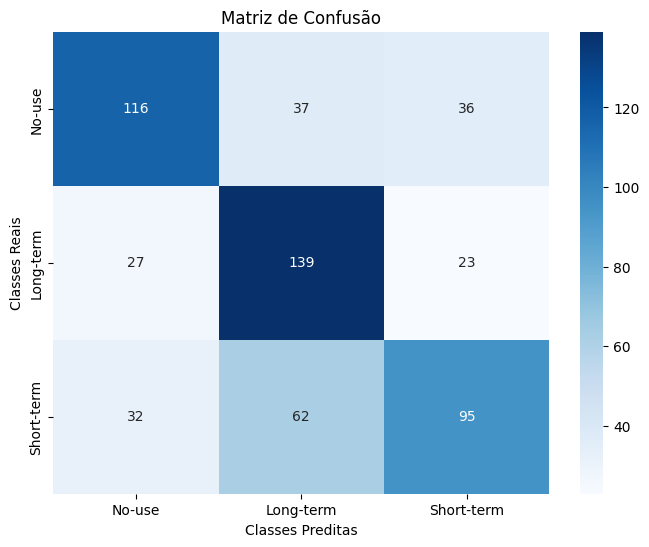

In [43]:
# Definir os nomes das classes a partir do mapeamento de rótulos
label_mapping = {1: 'No-use', 2: 'Long-term', 3: 'Short-term'}
target_names = [label_mapping[i] for i in sorted(label_mapping)]

# Verificar as classes presentes em y_test e y_pred para garantir que a matriz de confusão tenha apenas as classes relevantes
classes_in_y_test = np.unique(y_test)
classes_in_y_pred = np.unique(y_pred)

# Atualizar o mapeamento de classes para incluir apenas as classes que aparecem em y_test e y_pred
classes_to_use = sorted(set(classes_in_y_test).union(classes_in_y_pred))

# Calcular a matriz de confusão com as classes relevantes
cm = confusion_matrix(y_test, y_pred, labels=classes_to_use)

# Plotar a matriz de confusão com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusão")
plt.xlabel("Classes Preditas")
plt.ylabel("Classes Reais")
plt.savefig("matriz_confusao_2.png", dpi=300, bbox_inches='tight')
plt.show()
